# Finding the Optimal Ingredients for Quality White Wine

Michael Buyer

## Introduction

So some wine business wants to increase or even optimize satisfaction with the white wine product. No one wants to create products that people will rate poorly. The relevant dataset is about the white variant of Portuguese "Vinho Verde" wine. This and the information to be mentioned is from http://archive.ics.uci.edu/ml/datasets/Wine+Quality


The wine samples in the dataset are from north Portugal. "The goal is to model wine quality based on physicochemical tests". The wine quality follows integer values from 0 to 10 so I will treat this as a classification problem.

## Imports

In [51]:
import pandas as pd
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Support Vector Machine
from sklearn.svm import SVC

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Random Forests, Boosting
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

## Read Data

In [52]:
cd = pd.read_csv('winequality-white.csv',sep=';')
cd.shape

(4898, 12)

In [53]:
list(cd.columns)

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

We can see a variety of physical/chemical properties of the wine are sampled. 
Information that would ease the task at hand include grape types, wine brand, and wine selling price. However, privacy issues say I can't have that info.

In [54]:
cd.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [55]:
cd.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


Seeing the density values, I infer the density is what proportion of the solution is white wine. Maybe the remaining 0.02% of the solution is water or something. From prior knowledge, the low pH will mean wine is acidic indeed. 

## Histograms of Variables

Text(0, 0.5, 'observations')

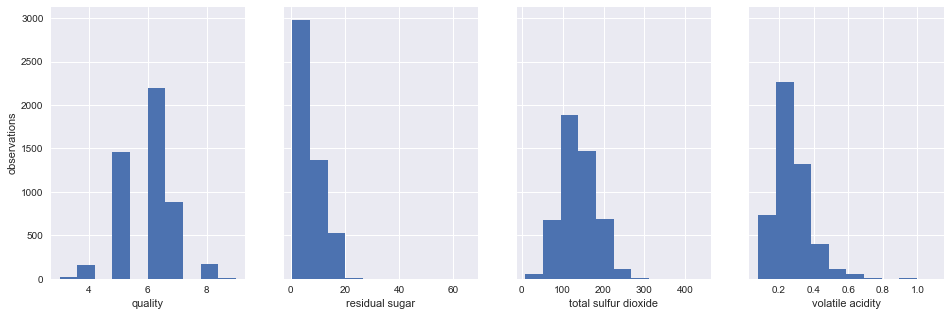

In [56]:
fig, axes = plt.subplots(ncols=4, sharey=True, figsize = (16,5))
axes[0].hist(cd['quality'])
axes[1].hist(cd['residual sugar'])
axes[2].hist(cd['total sulfur dioxide'])
axes[3].hist(cd['volatile acidity'])

axes[0].set_xlabel('quality')
axes[1].set_xlabel('residual sugar')
axes[2].set_xlabel('total sulfur dioxide')
axes[3].set_xlabel('volatile acidity')
axes[0].set_ylabel('observations')

residual sugar and volatile acidity are skewed, total sulfur dioxide is approximately normal.
Clearly a large majority of the quality is 5,6, or 7.

In [57]:
cd['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

so not every number from 0 to 10 is represented. A reason could be that the wine consumers didn't think the wine was perfect or absolutely terrible.
Then qualities of 3 and 9 appear to be outliers given how little observations there are in each. So I will turn 3's into 4's and 9's into 8's

In [58]:
cd['quality'] = cd['quality'].replace([3,9],[4,8])

In [59]:
cols = list(cd.columns)
cols.remove('quality') # every variable but quality is a feature
X = cd[cols].to_numpy()
y = cd['quality'].to_numpy()

I didn't end up using quality with its 5 different classes. Because even boosting couldn't muster > 0.7 accuracy there. I convert the 4 to 8 scale into poor, ok, and excellent, represented with 0,1, and 2

In [60]:
conditions = [
    (cd['quality'] <= 4), # poor
    (cd['quality'] > 4) & (cd['quality'] <= 7), # ok
    (cd['quality'] > 7) # excellent
    ]
vals = [0,1,2]
cd['rating'] = np.select(conditions, vals)

In [61]:
# artificially created rating
y = cd['rating'].to_numpy()

Now the main question is how these wines turn out ok (4) or great (8). In-between is relevant but not as interesting.

Just like how I would always start regression with linear regression, logistic regression will be the starting point here (without polynomial transform shenanigans)

## Logistic Regression

In [62]:


rng = np.random.RandomState(99)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state = rng, test_size=.25, stratify = y)
# stratified given the imbalance of class labels

# units for the features are not given but they are certainly on different scales
scl = StandardScaler()
Xtrain = scl.fit_transform(Xtrain)
Xtest = scl.transform(Xtest)

In [63]:
lfit = LogisticRegressionCV(penalty='l2', multi_class = 'multinomial', cv = 5)
# built in cross validation

lfit.fit(Xtrain,ytrain)
yhat = lfit.predict(Xtest)

yhat = yhat.reshape(-1, 1); ytest = ytest.reshape(-1, 1)
lfit.score(Xtest, ytest)


0.9257142857142857

92.57% isn't bad for the first try at classifying

In [66]:
lfit.coef_

array([[ 0.08338449,  0.43168997, -0.10086934, -0.91291661,  0.09814633,
        -0.35109959, -0.04341437,  0.76745964, -0.11638165, -0.02489671,
        -0.36010662],
       [-0.14775762, -0.12438308,  0.07241625,  0.0415515 ,  0.04674748,
         0.01402107,  0.10615856,  0.05305793, -0.14575867,  0.04110956,
        -0.08010287],
       [ 0.06437313, -0.30730689,  0.02845309,  0.87136511, -0.14489381,
         0.33707853, -0.06274419, -0.82051756,  0.26214032, -0.01621285,
         0.44020948]])

In [65]:
cd.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'rating'],
      dtype='object')

So the two features with the largest weights by a decent margin are residual sugar and density for 2 of the three classes 

## Naive Bayes

It is reasonable to assume the majority of the pairs of features are conditionally independent. Obvious dependent cases include pH and fixed acidity then free sulfur dioxide and total sulfur dioxide.

Gaussian Naive Bayes used because all the features are continuous (floats)

In [23]:
y = cd['rating'].to_numpy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state = rng, test_size=.25, stratify = y)

gNB = GaussianNB()
gNB.fit(Xtrain, ytrain)
yhat = gNB.predict(Xtest)

yhat = yhat.reshape(-1, 1); ytest = ytest.reshape(-1, 1)
gNB.score(Xtest, ytest)



0.876734693877551

Maybe should try with cross validation just like how logistic regression had it

In [26]:
X = cd[cols] #scaling should not be needed
y = cd['rating']

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5-fold
error = []
for train_index, test_index in skf.split(X, y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]  # train-test split
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    gNB.fit(Xtrain, ytrain)    # fit on train
    yhat = gNB.predict(Xtest)  # predict on test
    error.append(accuracy_score(ytest, yhat))   # model accuracy
print(error)
print(sum(error)/len(error))  # average accuracy

[0.8795918367346939, 0.8530612244897959, 0.8571428571428571, 0.8804902962206334, 0.881511746680286]
0.8703595922536532


nope, slightly worse than logistic regression apparently

## Random Forests

In [37]:
# scaling certainly not needed with trees
X = cd[cols]
y = cd['rating']

rng2 = np.random.RandomState(89)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state = rng, test_size=.25, stratify = y)

In [38]:
num_trees = 1000  # previous tuning says this
error = []
depths = [15,18,20,23,25] # try different depths
for param in depths:
    rf_mod = RandomForestClassifier(random_state = rng2, max_depth = param, n_estimators=num_trees)
    rf_mod.fit(Xtrain, ytrain)
    yhat = rf_mod.predict(Xtest)
    error.append(accuracy_score(ytest, yhat))
print(error)



[0.9314285714285714, 0.9371428571428572, 0.9395918367346939, 0.9412244897959183, 0.9412244897959183]


It's hard to visualize a tree with 15+ depth but it does surpass logistic regression

## Boosting

In [35]:
X = cd[cols]
y = cd['rating']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state = rng, test_size=.25, stratify = y)

In [36]:
booMod = GradientBoostingClassifier(n_estimators=500,learning_rate=.1,max_depth=10)
booMod.fit(Xtrain, ytrain)   
yhat = booMod.predict(Xtest) 
accuracy_score(ytest, yhat)

0.9444897959183673

of course the first boosting try with randomly chosen paramters does better than all the previous...

Time to enjoy tuning to see how close the accuracy can get to 1

In [42]:
# Search the grid of possible n_estimators, learning rates, and depths
estimators = np.array([100,500,1000])  
rates = np.array([.001, .01, .1])
depths = np.array([5,10,15])
hyperParams = np.array(np.meshgrid(estimators, rates, depths)).reshape(3,-1).T

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state = rng, test_size=.25, stratify = y)
error = []

for hp in hyperParams:
    booMod = GradientBoostingClassifier(n_estimators=int(hp[0]),learning_rate=hp[1],max_depth=int(hp[2]))
    booMod.fit(Xtrain, ytrain)
    yhat = booMod.predict(Xtest)  # predict on test
    error.append(accuracy_score(ytest, yhat))   # model accuracy
    print(hp, error[-1])

[1.e+02 1.e-03 5.e+00] 0.9257142857142857
[1.e+02 1.e-03 1.e+01] 0.9257142857142857
[1.0e+02 1.0e-03 1.5e+01] 0.9257142857142857
[5.e+02 1.e-03 5.e+00] 0.926530612244898
[5.e+02 1.e-03 1.e+01] 0.9257142857142857
[5.0e+02 1.0e-03 1.5e+01] 0.9257142857142857
[1.e+03 1.e-03 5.e+00] 0.926530612244898
[1.e+03 1.e-03 1.e+01] 0.9379591836734694
[1.0e+03 1.0e-03 1.5e+01] 0.9412244897959183
[1.e+02 1.e-02 5.e+00] 0.926530612244898
[1.e+02 1.e-02 1.e+01] 0.9387755102040817
[1.0e+02 1.0e-02 1.5e+01] 0.9412244897959183
[5.e+02 1.e-02 5.e+00] 0.9379591836734694
[5.e+02 1.e-02 1.e+01] 0.9412244897959183
[5.0e+02 1.0e-02 1.5e+01] 0.9420408163265306
[1.e+03 1.e-02 5.e+00] 0.9387755102040817
[1.e+03 1.e-02 1.e+01] 0.9428571428571428
[1.0e+03 1.0e-02 1.5e+01] 0.9420408163265306
[100.    0.1   5. ] 0.9395918367346939
[100.    0.1  10. ] 0.9404081632653061
[100.    0.1  15. ] 0.9404081632653061
[5.e+02 1.e-01 5.e+00] 0.9387755102040817
[5.e+02 1.e-01 1.e+01] 0.9428571428571428
[5.0e+02 1.0e-01 1.5e+01] 0.

1000 trees, 0.1 learning rate, and 10 depth for 0.9445

## Feature Importance

Ok time to take a step back because this is not an accuracy game. Random forests conveniently has feature importances

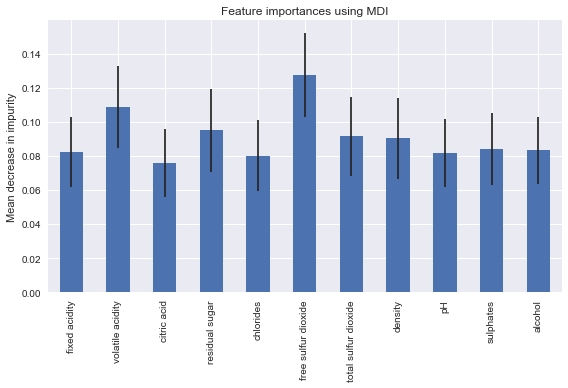

In [43]:
feature_names = cols
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state = rng, test_size=.25, stratify = y)
rfMod = RandomForestClassifier(random_state= rng2, max_depth = 20, n_estimators=1000)
rfMod.fit(Xtrain, ytrain)

# This particular importance measurement may be inaccurate due to "high cardinality" features
importances = rfMod.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfMod.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Not very helpful, will permutation importance be any better

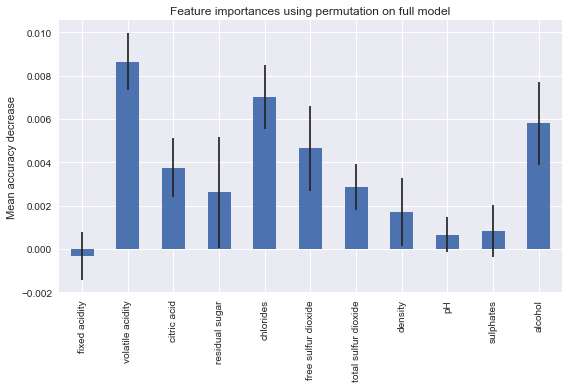

In [44]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rfMod, Xtest, ytest, n_repeats=10, random_state=42)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()


Fixed acidity apparently might decrease accuracy. pH and sulphates don't mean much according to the particular random forests model

It's also possble to visualize a tree with low depth

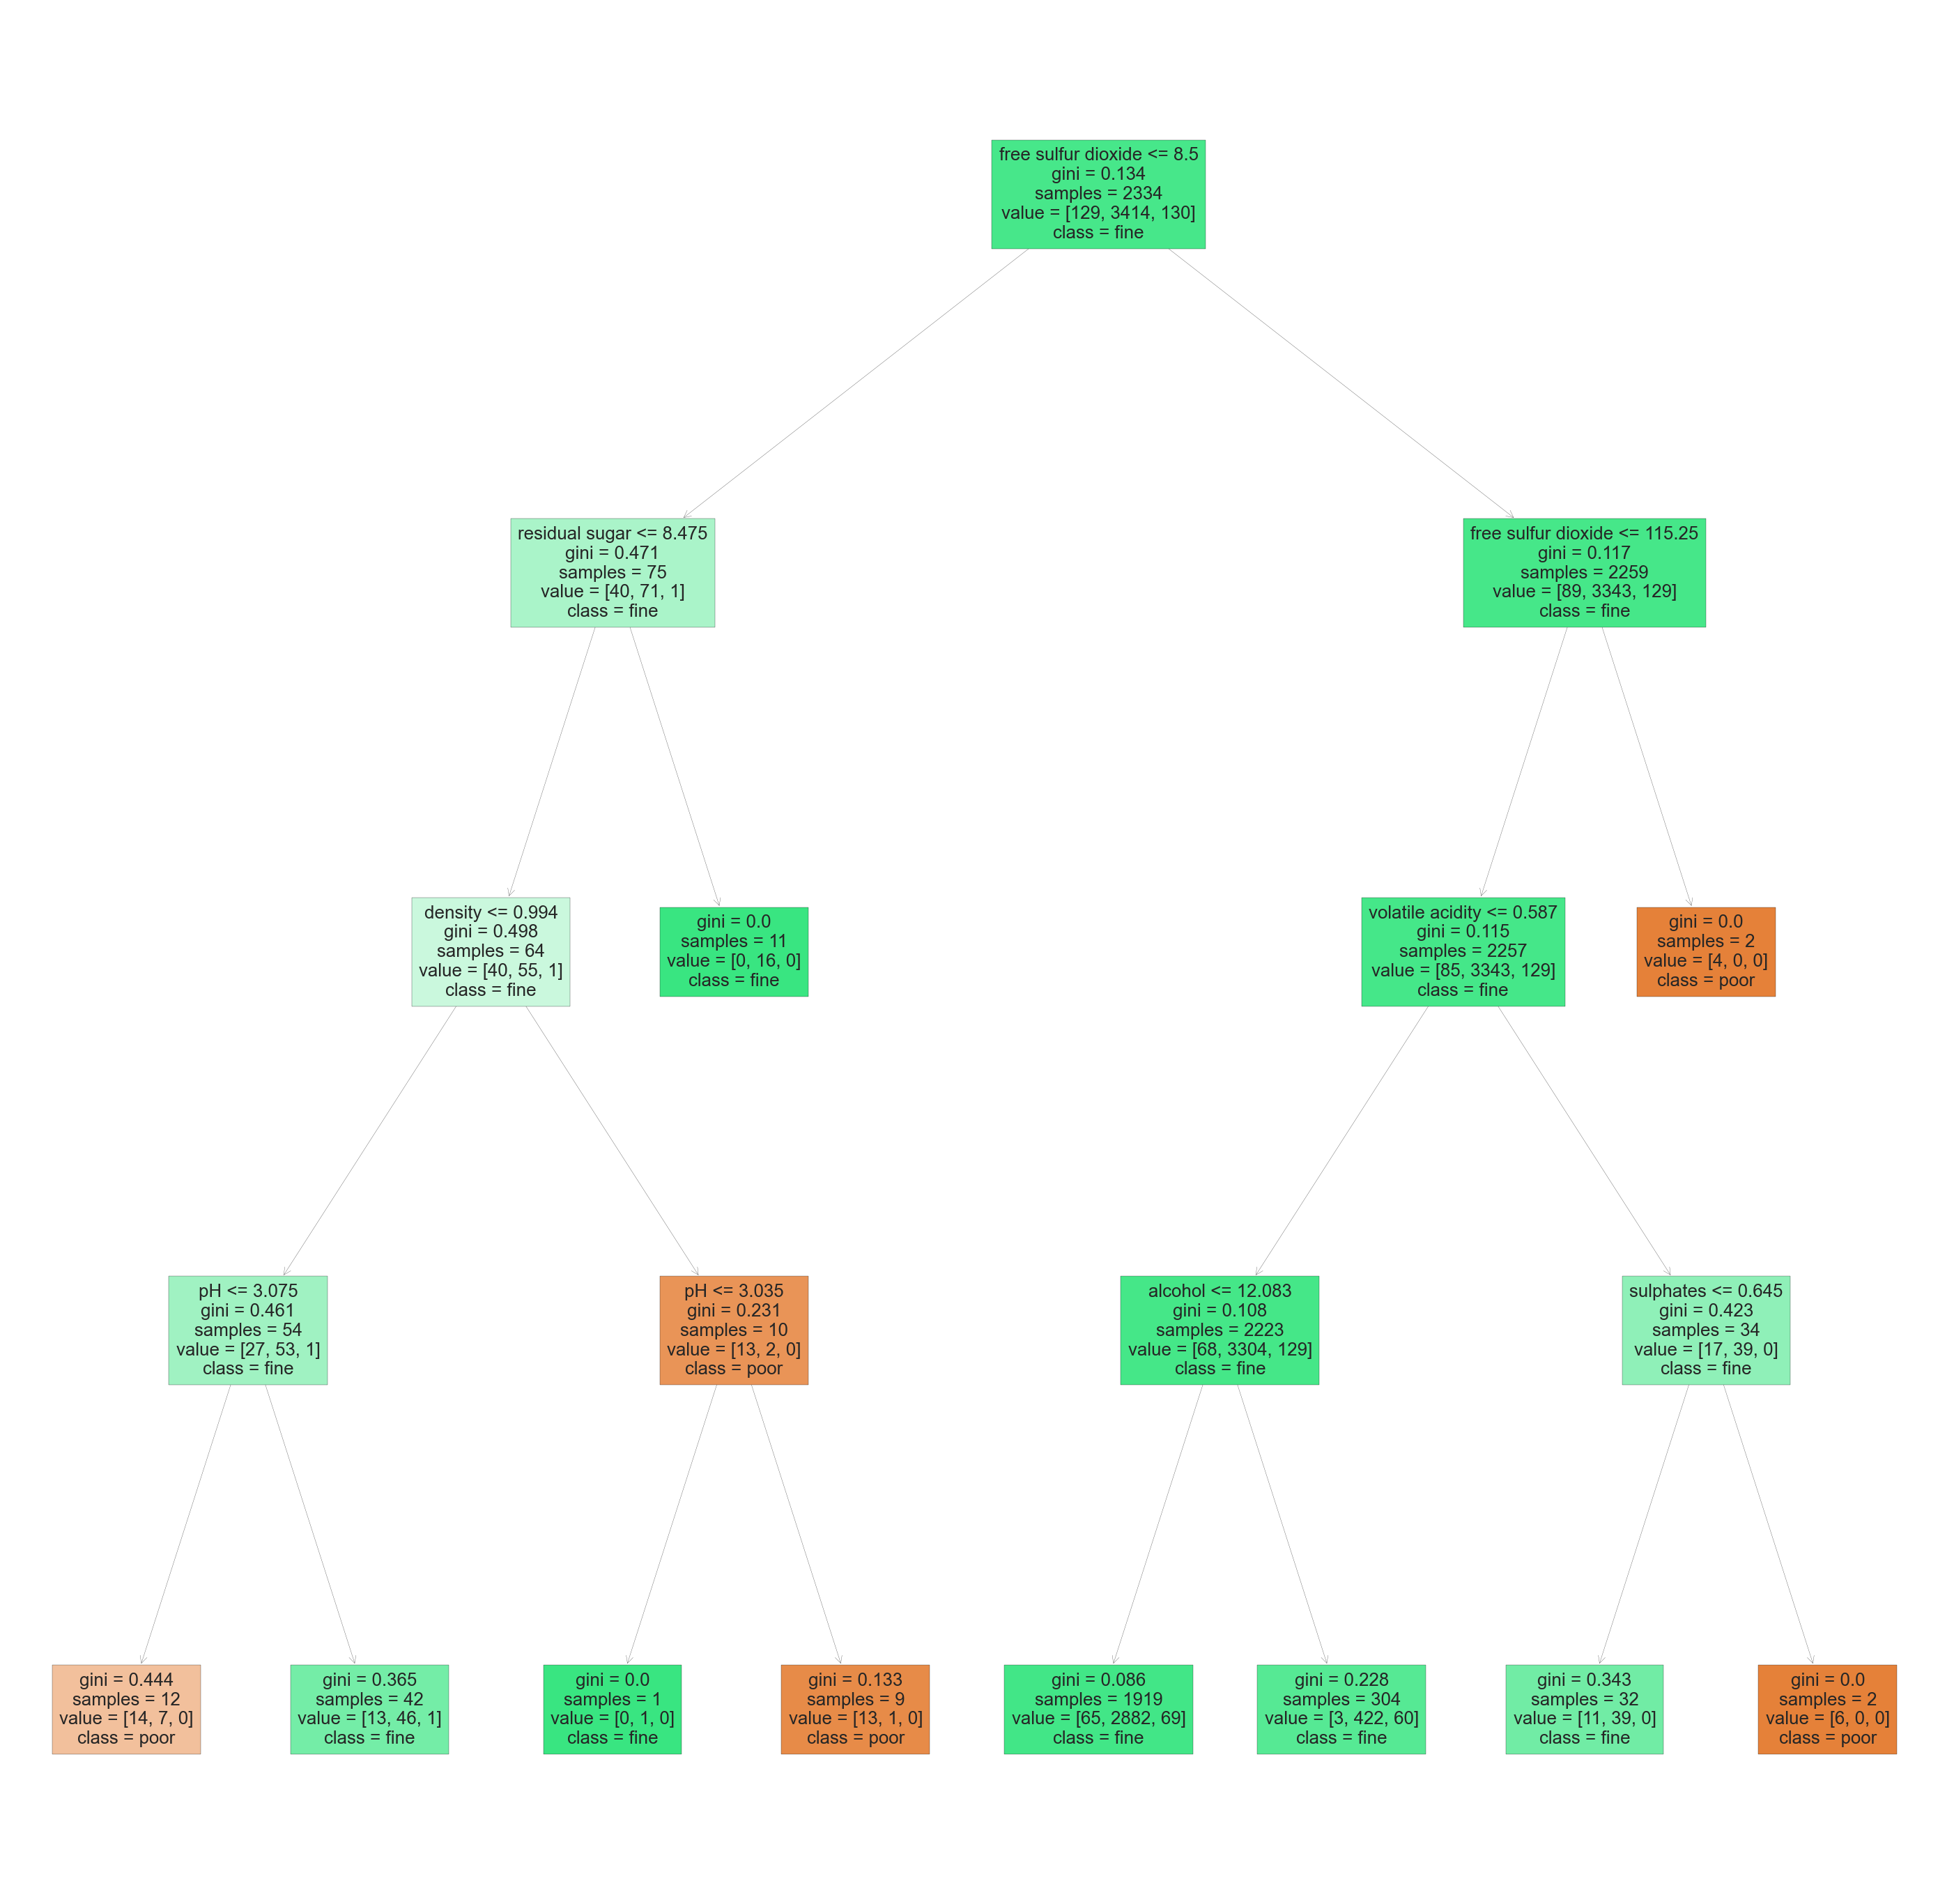

In [75]:
X = cd[cols]
y = cd['rating']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state = rng2, test_size=.25, stratify = y)


# Visualize the tree
from sklearn import tree
clf = RandomForestClassifier(max_depth = 4, random_state = rng2, n_estimators=1000)
clf.fit(Xtrain, ytrain)
estimator = clf.estimators_[66]

fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(estimator, feature_names = cols, class_names = ['poor', 'fine', 'excellent'], filled=True)

In a last ditch effort to understand the feature importances

In [72]:
cd.groupby('rating').count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
rating,,,,,,,,,,,,
0,183,183,183,183,183,183,183,183,183,183,183,183
1,4535,4535,4535,4535,4535,4535,4535,4535,4535,4535,4535,4535
2,180,180,180,180,180,180,180,180,180,180,180,180


In [73]:
cd.groupby('rating')[cols].mean()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
rating,,,,,,,,,,,
0,7.180874,0.375984,0.307705,4.821038,0.050557,26.633880,130.232240,0.994343,3.183388,0.475956,10.173497
1,6.848633,0.274308,0.335499,6.485072,0.045887,35.605733,139.183903,0.994087,3.187158,0.490573,10.482895
2,6.678333,0.277972,0.328167,5.628333,0.038011,36.627778,125.883333,0.992214,3.221167,0.485667,11.651111


bring up logistic regression coefficients again

In [74]:
lfit.coef_

array([[ 0.08338449,  0.43168997, -0.10086934, -0.91291661,  0.09814633,
        -0.35109959, -0.04341437,  0.76745964, -0.11638165, -0.02489671,
        -0.36010662],
       [-0.14775762, -0.12438308,  0.07241625,  0.0415515 ,  0.04674748,
         0.01402107,  0.10615856,  0.05305793, -0.14575867,  0.04110956,
        -0.08010287],
       [ 0.06437313, -0.30730689,  0.02845309,  0.87136511, -0.14489381,
         0.33707853, -0.06274419, -0.82051756,  0.26214032, -0.01621285,
         0.44020948]])

## Conclusion

None of the models have extraordinary accuracy but they uncover reasons why people may rate certain wines better than others.

Advice to the wine business in question would be: carefully make the wine less acidic than on average before, increase free sulfur dioxide, and slightly increase alcoholic content.
However, we all know this isn't optimal due to hidden information about grape types, wine brand, and wine selling price. Adjusting for price probably leads to a completely different conclusion.
Ethics is then a whole separate question requiring studying of Portuguese wine culture.

I would have certainly tested neural networks as the next step.